In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load Libraries

In [2]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim import corpora
import gensim
from gensim.utils import simple_preprocess

import re

from nltk.corpus import stopwords
from src.data.make_dataset import lematize

from sklearn.decomposition import TruncatedSVD

import pyLDAvis
import pyLDAvis.gensim 

from src.data.DBConnection import DBConnection
db = DBConnection()

# Build Features

In [4]:
sql = "SELECT details FROM positions;"
query = db.cur.execute(sql)
documents = query.fetchall()

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def process_documents(documents):
    # try new preprocessing steps:
    data = list(documents)
    # remove \n
    data = [text[0].replace("\n", " ") for text in data]
    # remove https:// links 
    data = [re.sub(r"((https{0,1}\:/\/\w{3}\S+)|(w{3}\S+))", "", text) for text in data]
    # remove emails:
    data = [re.sub(r"(\S+@\S+)", "", text) for text in data]
    # remove phone numbers:
    data = [re.sub(r"([\+\s01-]*\(*\d{3}\)*[-\s]\d{3}[-\s]\d{4})", "", text) for text in data]
    # remove uf0b7
    data = [re.sub(r"(\uf0b7)", "", text) for text in data]
    # remove handles:
    data = [re.sub(r"(\@\S+)", "", text) for text in data]
    # remove french documents
    data = [doc for doc in data if "une" not in doc and "connaissance" not in doc]
    return data

def docs_to_words(documents):
    for doc in documents:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# get stop words and add some super-common words amoung the documents
stop_words = stopwords.words('english')
stop_words.extend(["work", "experience", "team", "technology", "skill", "information", "project", "projects", "skills"])

# clean all the documents (i.e., use regex to remove emails, urls, phone numbers, french documents, etc.)
clean_docs = process_documents(documents)

# use simple_preprocess to remove punctuation:
data_words = list(docs_to_words(clean_docs))

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=500) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=500)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form trigrams:
data_words_trigrams = make_trigrams(data_words_bigrams)

# Lematize docs:
data_lemmatized = [lematize(words).split(" ") for words in data_words_trigrams]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 29.2 s


In [37]:
%%time
# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 586 ms


# PCA
See if PCA might be useful, also will be used to visualize the LDA model later.

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


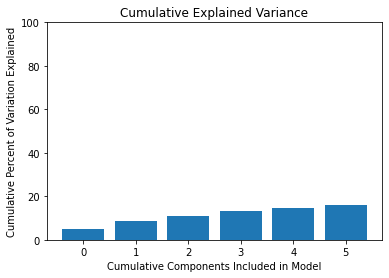

In [46]:
# initialize PCA:
# reduce features:
num_topics = 6
pca = PCA(n_components=num_topics)
dense_corpus = gensim.matutils.corpus2dense(corpus, len(id2word.keys()))
reduced_features = pca.fit_transform(dense_corpus.T)

# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [47]:
import pandas as pd
loadings = pd.DataFrame(data=pca.components_, columns=id2word.values()).T
topics = pd.DataFrame()
for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:3].index.tolist()
    
topics

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5
0,learn,management,engineering,model,product,customer
1,model,client,design,machine,customer,security
2,analytics,process,civil,solution,security,service


It looks like PC0 might be dominated by descriptions that have a customer base while PC1 is more for managment support.

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


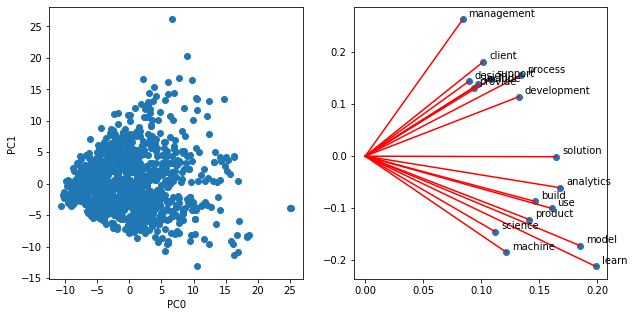

In [34]:
# plot loadings and score:
x = 0
y = 1
threshold = 0.16

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(
    x=reduced_features[:,x], y=reduced_features[:,y]
)
ax1.set_xlabel(f"PC{x}")
ax1.set_ylabel(f"PC{y}")

ax2 = fig.add_subplot(1, 2, 2)
loadings_plot = loadings[(loadings[x]**2 + loadings[y]**2)**0.5 > threshold][[x, y]]
plt.scatter(x=loadings_plot[x], y=loadings_plot[y])
for label, (_x, _y) in loadings_plot.iterrows():
    plt.plot([0, _x], [0,_y], 'r')
    plt.text(_x+0.005, _y+0.005, label)

# SVD

In [51]:
svd_model = TruncatedSVD(n_components=6,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)
svd_matrix = svd_model.fit_transform(dense_corpus.T)

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


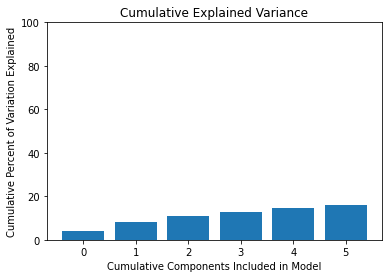

In [52]:
# display percent explained variance of the first ten components:
plt.figure()
plt.bar(x=range(len(svd_model.explained_variance_ratio_)), height=np.cumsum(svd_model.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [53]:
loadings = pd.DataFrame(data=svd_model.components_, columns=id2word.values()).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5
0,skill,project,financial,model,learn,customer
1,project,management,accounting,analytics,machine,security
2,process,civil,process,skill,accounting,system
3,service,engineering,report,analysis,model,service
4,level,client,account,solution,financial,cloud
5,engineering,design,finance,management,account,software
6,opportunity,construction,analysis,develop,ai,solution
7,time,report,skill,knowledge,prepare,engineering
8,management,accounting,analyst,machine,research,management
9,industry,ability,ensure,analytical,ml,process


# LDA

In [12]:
logging.getLogger().setLevel(logging.ERROR)

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 1min 10s


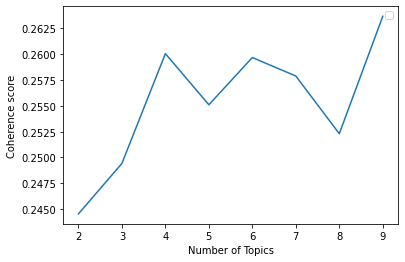

In [40]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# determine optimal number of topics using coherence score:
coherence_vals = []
model_list =[]
start = 2
stop = 10
step = 1

for num_topics in range(start, stop, step):
    # make LDa model and calc coherence:
    model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, )
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v', processes=1)
    coherence_vals.append(coherence_model.get_coherence())
    
x = range(start, stop, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend()

In [14]:
best_model = model_list[coherence_vals.index(max(coherence_vals))]

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
best_model = model_list[3]
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
vis

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.006036 -0.004090       1        1  32.683296
3     -0.010789 -0.001938       2        1  25.032590
0      0.003320 -0.003932       3        1  17.578218
1     -0.001358  0.002641       4        1  16.097586
2      0.002791  0.007319       5        1   8.608310, topic_info=            Term         Freq        Total Category  logprob  loglift
239         year  1411.000000  1411.000000  Default  30.0000  30.0000
565  opportunity  1718.000000  1718.000000  Default  29.0000  29.0000
67   engineering  1830.000000  1830.000000  Default  28.0000  28.0000
65    employment  1520.000000  1520.000000  Default  27.0000  27.0000
299      include  1516.000000  1516.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
328      project   133.161425  2039.028076   Topic5  -5.5031  -0.2762
168      product   117.919268  1598.129318   Topic5  -5.6246  -0.1541
223          use   115.517094  1546.381854   Topic5  -5.6452  -0.1418
525  environment   109.005947  1377.648494   Topic5  -5.7032  -0.0843
205      support   112.758001  1749.355741   Topic5  -5.6694  -0.2893

[446 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.383381  ability
0         2  0.198233  ability
0         3  0.221785  ability
0         4  0.139352  ability
0         5  0.057573  ability
...     ...       ...      ...
3300      1  0.185307    zynga
3300      2  0.185307    zynga
3300      3  0.370614    zynga
3300      4  0.185307    zynga
3300      5  0.092654    zynga

[1192 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 3])

In [42]:
# display topics:
topic_dist = pd.DataFrame(data=model_list[5].get_topics(), columns=id2word.values()).T
lda_topics = pd.DataFrame()

for topic in topic_dist.columns:
    lda_topics[f"topic_{topic}"] = topic_dist[topic].sort_values(ascending=False)[:8].index
    
lda_topics

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,time,opportunity,time,include,work,engineering,service
1,customer,job,employment,product,learn,level,job
2,service,process,level,opportunity,use,service,process
3,industry,industry,learn,support,service,industry,client
4,process,management,service,job,solution,process,level
5,level,engineering,engineering,provide,company,design,design
6,learn,development,management,service,development,job,management
7,ability,level,use,management,level,full,solution


c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


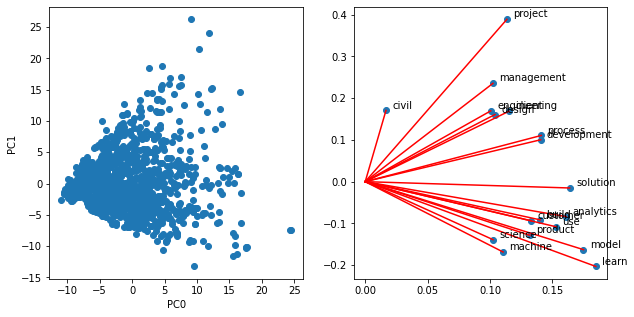

In [59]:
fig

# Improve Results

## Frequency Filter

# Observations

It looks like the topics are not well modelled, and I suspect that the dataset contains only similar documents, and therefore there are not inherent topics. This dataset might do well as a training algorithm to CREATE job postings.